In [1]:
import pandas as pd
import json
import gzip
# sudo pip install pandas


In [2]:
def json_gz_to_dataframe(gz_file_path):
    data = []
    
    # Open and read the gzipped JSON file
    with gzip.open(gz_file_path, 'rt') as file:
        # Read the file line-by-line
        for line in file:
            try:
                json_data = json.loads(line)  # Load each line as a separate JSON object
                
                # Loop through the transcripts in the JSON data
                for transcript_id, positions in json_data.items():
                    for position, sequences in positions.items():
                        for sequence, reads in sequences.items():
                            # Create the 5-mers for the position -1, 0, and 1 from the 7-mer (sequence)
                            fivemer_neg_1 = sequence[:5]  # First 5 nucleotides (e.g., "AAGAC")
                            fivemer_0 = sequence[1:6]     # Middle 5 nucleotides (e.g., "AGACC")
                            fivemer_1 = sequence[2:]      # Last 5 nucleotides (e.g., "GACCA")
                            
                            # For each read in the list of reads, create a row
                            for read in reads:
                                row = [
                                    transcript_id,                # transcript_id
                                    int(position)-1,              # position_neg_1
                                    read[0], read[1], read[2],    # dwelling_time_neg_1, sd_neg_1, mean_neg_1
                                    int(position),                # position_0
                                    read[3], read[4], read[5],    # dwelling_time_0, sd_0, mean_0
                                    int(position)+1,              # position_1
                                    read[6], read[7], read[8],    # dwelling_time_1, sd_1, mean_1
                                    sequence,                     # ori_nucleotide (7-mer)
                                    fivemer_neg_1,                # fivemer_neg_1
                                    fivemer_0,                    # fivemer_0
                                    fivemer_1                     # fivemer_1
                                ]
                                data.append(row)
            except json.JSONDecodeError:
                print(f"Skipping invalid JSON line: {line}")
    
    # Define the columns, including the new 5-mer and ori_nucleotide columns
    columns = [
        'transcript_id', 'position_neg_1', 'dwelling_time_neg_1', 'sd_neg_1', 'mean_neg_1',
        'transcript_position', 'dwelling_time_0', 'sd_0', 'mean_0',
        'position_1', 'dwelling_time_1', 'sd_1', 'mean_1',
        'ori_nucleotide', 'fivemer_neg_1', 'fivemer_0', 'fivemer_1'
    ]
    
    # Create the dataframe
    df = pd.DataFrame(data, columns=columns)
    
    return df

# Example usage
# df = json_gz_to_dataframe('dataset0.json.gz')  # Replace with actual path
# print(df.head())

In [100]:
df = json_gz_to_dataframe('data/dataset0.json.gz')  # Replace with actual path
print(df.head())

df.to_csv('data/dataset0.csv', index=False) # save file as csv

In [7]:
# Step 1: Read in the 'data.info.labelled' file
# Adjust 'sep' based on the format (e.g., ',' for CSV or '\t' for tab-separated files)
data_info = pd.read_csv('data/data.info.labelled', sep=',')

df = pd.read_csv('data/dataset0.csv')

# Step 2: Perform the merge using 'transcript_id'
merged_df = pd.merge(df, data_info, on=['transcript_id', 'transcript_position'], how='inner')

merged_df.to_csv('data/merged_df.csv', index=False)
# Step 3: Display the merged DataFrame
print(merged_df.head())

# studies/ProjectStorage/data/merged_df.csv

     transcript_id  position_neg_1  dwelling_time_neg_1  sd_neg_1  mean_neg_1  \
0  ENST00000000233             243              0.00299      2.06       125.0   
1  ENST00000000233             243              0.00631      2.53       125.0   
2  ENST00000000233             243              0.00465      3.92       109.0   
3  ENST00000000233             243              0.00398      2.06       125.0   
4  ENST00000000233             243              0.00664      2.92       120.0   

   position_0  dwelling_time_0   sd_0  mean_0  position_1  dwelling_time_1  \
0         244          0.01770  10.40   122.0         245          0.00930   
1         244          0.00844   4.67   126.0         245          0.01030   
2         244          0.01360  12.00   124.0         245          0.00498   
3         244          0.00830   5.01   130.0         245          0.00498   
4         244          0.00266   3.94   129.0         245          0.01300   

    sd_1  mean_1          gene_id  label  
0

### Start from here

In [1]:
# Change this file path
import pandas as pd
df = pd.read_csv("~/Desktop/NUS/Y4/DSA4262/Team_Project/data/merged_data.csv")
# df = pd.read_csv("studies/ProjectStorage/data/merged_data.csv")
df.head()


,transcript_id,position_neg_1,dwelling_time_neg_1,sd_neg_1,mean_neg_1,transcript_position,dwelling_time_0,sd_0,mean_0,position_1,dwelling_time_1,sd_1,mean_1,ori_nucleotide,fivemer_neg_1,fivemer_0,fivemer_1,gene_id,label
0,ENST00000000233,243,0.00299,2.06,125.0,244,0.01770,10.40,122.0,245,0.00930,10.90,84.1,AAGACCA,AAGAC,AGACC,GACCA,ENSG00000004059,0
1,ENST00000000233,243,0.00631,2.53,125.0,244,0.00844,4.67,126.0,245,0.01030,6.30,80.9,AAGACCA,AAGAC,AGACC,GACCA,ENSG00000004059,0
2,ENST00000000233,243,0.00465,3.92,109.0,244,0.01360,12.00,124.0,245,0.00498,2.13,79.6,AAGACCA,AAGAC,AGACC,GACCA,ENSG00000004059,0
3,ENST00000000233,243,0.00398,2.06,125.0,244,0.00830,5.01,130.0,245,0.00498,3.78,80.4,AAGACCA,AAGAC,AGACC,GACCA,ENSG00000004059,0
4,ENST00000000233,243,0.00664,2.92,120.0,244,0.00266,3.94,129.0,245,0.01300,7.15,82.2,AAGACCA,AAGAC,AGACC,GACCA,ENSG00000004059,0


### drop columns and rename

In [2]:
df = df.drop(columns=["ori_nucleotide","fivemer_neg_1","fivemer_0","fivemer_1"])

In [ ]:
# df.rename(columns={'position_0': 'transcript_position'}, inplace=True)

In [3]:
df.columns

Index(['transcript_id', 'position_neg_1', 'dwelling_time_neg_1', 'sd_neg_1',
       'mean_neg_1', 'transcript_position', 'dwelling_time_0', 'sd_0',
       'mean_0', 'position_1', 'dwelling_time_1', 'sd_1', 'mean_1', 'gene_id',
       'label'],
      dtype='object')

### Feature Engineering

In [20]:
def feature_engineeer_mean(df):
    columns_to_average = ['dwelling_time_neg_1', 'dwelling_time_0', 'dwelling_time_1', 
                      'mean_neg_1', 'mean_0', 'mean_1', 
                      'sd_neg_1', 'sd_0', 'sd_1']

    # Group by 'transcript_id' and 'gene_id' and calculate the mean for each column
    averaged_df = df.groupby(['transcript_id', 'transcript_position']).agg({
        'dwelling_time_neg_1': ['mean', 'min', 'max', 'median'],
        'dwelling_time_0': ['mean', 'min', 'max', 'median'],
        'dwelling_time_1': ['mean', 'min', 'max', 'median'],
        'mean_neg_1': ['mean', 'min', 'max', 'median'],
        'mean_0': ['mean', 'min', 'max', 'median'],
        'mean_1': ['mean', 'min', 'max', 'median'],
        'sd_neg_1': ['mean', 'min', 'max', 'median'],
        'sd_0': ['mean', 'min', 'max', 'median'],
        'sd_1': ['mean', 'min', 'max', 'median'],
    }).reset_index()

    # Rename columns to desired format
    averaged_df.columns = [
        f'{col[0]}_{col[1]}' if col[1] != '' else col[0]  # Join column names with '_'
        for col in averaged_df.columns
    ]

    return averaged_df

# averaged_df = feature_engineeer_mean(df)

In [21]:
# get number of reads for each transcript

def feature_engineer_read_count(df):
    df['read_count'] = df.groupby([ 'transcript_id'])['transcript_id'].transform('count')
    return df

# averaged_df = feature_engineer_read_count(averaged_df)

In [22]:
# Encode categorical variables
def encode_nucleotide_sequence(sequence):
    encoding = []
    for nucleotide in sequence:
        if nucleotide == 'A':
            encoding.extend([1, 0, 0, 0])
        elif nucleotide == 'C':
            encoding.extend([0, 1, 0, 0])
        elif nucleotide == 'G':
            encoding.extend([0, 0, 1, 0])
        elif nucleotide == 'T':
            encoding.extend([0, 0, 0, 1])
    return encoding

def encode_nucleotides(df):
    for i in range(7):  # For each of the 7 positions in the sequence
        df[f'A_{i + 1}'] = df['ori_nucleotide'].apply(lambda x: encode_nucleotide_sequence(x)[i * 4])
        df[f'C_{i + 1}'] = df['ori_nucleotide'].apply(lambda x: encode_nucleotide_sequence(x)[i * 4 + 1])
        df[f'G_{i + 1}'] = df['ori_nucleotide'].apply(lambda x: encode_nucleotide_sequence(x)[i * 4 + 2])
        df[f'T_{i + 1}'] = df['ori_nucleotide'].apply(lambda x: encode_nucleotide_sequence(x)[i * 4 + 3])

    return df

# df = encode_nucleotides(df)
# averaged_df = encode_nucleotides(averaged_df)

In [23]:
def reorder_columns(df):
    # reorder the ACGT to show first 4 columns as position 1, next 4 cols as position 2....
    ordered_columns = []

    # Loop to append A, C, G, T in the desired order
    for i in range(1, 8):  # Assuming you want A_1 to A_7, C_1 to C_7, etc.
        ordered_columns.extend([f'A_{i}', f'C_{i}', f'G_{i}', f'T_{i}'])

    # Identify other columns that are not part of A, C, G, T
    other_columns = [col for col in df.columns if col not in ordered_columns]

    # Final column order
    final_order = other_columns + ordered_columns
    df = df[final_order]
    return df

# df = reorder_columns(df)
# averaged_df = reorder_columns(averaged_df)

In [24]:
# rolling difference for mean only
def add_rolling(df):
    # Define the pairs of columns to calculate differences for each metric
    calculations = {
        'dwelling_time': [('dwelling_time_neg_1_mean', 'dwelling_time_0_mean'), 
                          ('dwelling_time_0_mean', 'dwelling_time_1_mean')],
        'mean': [('mean_neg_1_mean', 'mean_0_mean'), 
                 ('mean_0_mean', 'mean_1_mean')],
        'sd': [('sd_neg_1_mean', 'sd_0_mean'), 
               ('sd_0_mean', 'sd_1_mean')]
    }

    for metric, pairs in calculations.items():
        for first, second in pairs:
            # Create a new column with a unique name for the difference
            df[f'{metric}_diff_{first}_{second}'] = df[first] - df[second]
    
    return df

# df = add_rolling(df)
# averaged_df = add_rolling(averaged_df)

In [25]:
def get_unique_transcript_count(df):
    # Number of unique transcript IDs per gene ID
    df['unique_transcript_count_per_gene'] = df.groupby('gene_id')['transcript_id'].transform('nunique')
    return df

# df = get_unique_transcript_count(df)
# averaged_df = get_unique_transcript_count(averaged_df)

### Normalise

In [26]:
from sklearn.preprocessing import StandardScaler

def normalise(df):
    # Initialize the scaler
    scaler = StandardScaler()

    excluded_columns = ['transcript_id', 'gene_id', 'transcript_position', 'label_first']

    # List of columns to scale
    scaled_columns = [col for col in df.columns if col not in excluded_columns]

    # Scale the selected columns
    df[scaled_columns] = scaler.fit_transform(df[scaled_columns])
    # Check the modified DataFrame
    return df


### Splitting the dataset

In [17]:
from sklearn.model_selection import GroupShuffleSplit

X = averaged_df.drop(columns=['label_first'])  # All columns except the label column
y = averaged_df['label_first']  # The target label

# Define the group column (gene_id in this case)
groups = averaged_df['gene_id']

# Initialize GroupShuffleSplit with desired parameters
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

# Perform the train-test split
for train_idx, test_idx in gss.split(X, y, groups=groups):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]



In [18]:
X_train = X_train.drop(columns=['transcript_id', 'gene_id','transcript_position'], errors='ignore')

In [20]:
X_train.columns

Index(['dwelling_time_neg_1_mean', 'dwelling_time_neg_1_min',
       'dwelling_time_neg_1_max', 'dwelling_time_neg_1_median',
       'dwelling_time_0_mean', 'dwelling_time_0_min', 'dwelling_time_0_max',
       'dwelling_time_0_median', 'dwelling_time_1_mean', 'dwelling_time_1_min',
       'dwelling_time_1_max', 'dwelling_time_1_median', 'mean_neg_1_mean',
       'mean_neg_1_min', 'mean_neg_1_max', 'mean_neg_1_median', 'mean_0_mean',
       'mean_0_min', 'mean_0_max', 'mean_0_median', 'mean_1_mean',
       'mean_1_min', 'mean_1_max', 'mean_1_median', 'sd_neg_1_mean',
       'sd_neg_1_min', 'sd_neg_1_max', 'sd_neg_1_median', 'sd_0_mean',
       'sd_0_min', 'sd_0_max', 'sd_0_median', 'sd_1_mean', 'sd_1_min',
       'sd_1_max', 'sd_1_median', 'read_count',
       'dwelling_time_diff_dwelling_time_neg_1_mean_dwelling_time_0_mean',
       'dwelling_time_diff_dwelling_time_0_mean_dwelling_time_1_mean',
       'mean_diff_mean_neg_1_mean_mean_0_mean',
       'mean_diff_mean_0_mean_mean_1_mean',

### Feature Selection via Random Forest

In [21]:
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns

def rf_feature_selector(X, y):
    # Train the Random Forest model
    model = RandomForestClassifier(random_state=42)
    model.fit(X, y)
    
    # Get feature importances
    importances = model.feature_importances_
    
    # Create a Series for feature importances
    feature_importances = pd.Series(importances, index=X.columns)
    
    # Visualize feature importances
    plt.figure(figsize=(10, 6))
    sns.barplot(x=feature_importances.sort_values(ascending=False), y=feature_importances.sort_values(ascending=False).index)
    plt.title('Feature Importances from Random Forest')
    plt.xlabel('Importance Score')
    plt.ylabel('Features')
    plt.show()
    
    # Get top 10 features
    top_features = feature_importances.nlargest(10).index.tolist()
    
    # Select the top features from the original DataFrame
    X_selected = X[top_features]
    
    return X_selected, top_features

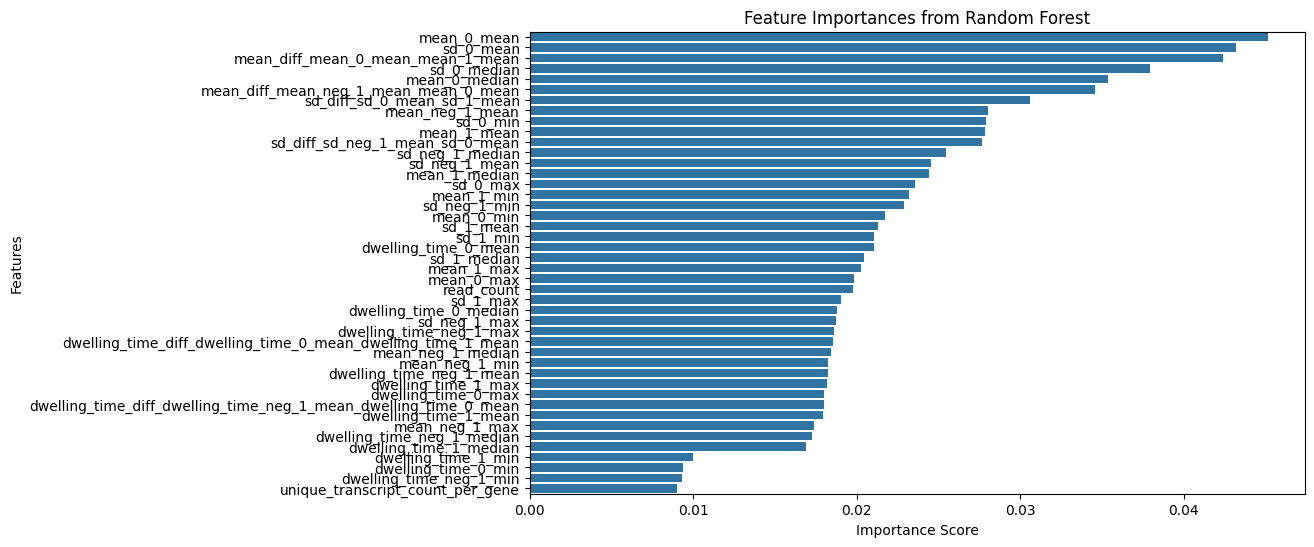

In [22]:
X_selected, top_features = rf_feature_selector(X_train,y_train)

In [23]:
top_features

['mean_0_mean',
 'sd_0_mean',
 'mean_diff_mean_0_mean_mean_1_mean',
 'sd_0_median',
 'mean_0_median',
 'mean_diff_mean_neg_1_mean_mean_0_mean',
 'sd_diff_sd_0_mean_sd_1_mean',
 'mean_neg_1_mean',
 'sd_0_min',
 'mean_1_mean']

In [24]:
# Update feature sets with selected features from Random Forest
X_train_selected = X_train[top_features]
X_test_selected = X_test[top_features]

In [34]:
X_test = X_test.drop(columns=['transcript_id', 'gene_id','transcript_position'], errors='ignore')

### Apply SMOTE

In [25]:
# See class distribution before SMOTE
print("Class distribution in training set before SMOTE:")
print(y_train.value_counts())

# label                                                                           
# 0    93715                                                                      
# 1     4291 

Class distribution in training set before SMOTE:
label_first
0    93715
1     4291
Name: count, dtype: int64


In [26]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
X_train_selected_resampled, y_train_resampled = smote.fit_resample(X_train_selected, y_train)
print("Class distribution in training set after SMOTE:")
print(pd.Series(y_train_resampled).value_counts())
#  Both Label 0 and 1: 93715 each                                                                       

Class distribution in training set after SMOTE:
label_first
0    93715
1    93715
Name: count, dtype: int64


### Model Training and Fitting

In [45]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from nltk.classify.scikitlearn import SklearnClassifier
#import xgboost as xgb
from sklearn.svm import SVC
import copy
# Setting up the pipelines for various models
pipelines = {
    # 'logistic': make_pipeline(StandardScaler(), LogisticRegression(max_iter=200,random_state=42)),
#    'rf': make_pipeline(StandardScaler(), RandomForestClassifier(n_estimators=100, random_state=42)),
#     'gb': make_pipeline(StandardScaler(), GradientBoostingClassifier(n_estimators=100, random_state=42)),
#     'xgb': make_pipeline(StandardScaler(), xgb.XGBClassifier(n_estimators=100, random_state=42)),
    'svm': make_pipeline(StandardScaler(), SVC(probability=True)) 
}

In [46]:
print("Training and evaluating models with all features:")
# Fit models with all features
for name, pipeline in pipelines.items():
    pipeline.fit(X_train_resampled, y_train_resampled)
    # Evaluate model performance
    train_score = pipeline.score(X_train_resampled, y_train_resampled)
    print(f"{name}: Training Score: {train_score}")

Training and evaluating models with all features:
svm: Training Score: 0.9350584218108093


In [47]:
pipelines_selected = {name: copy.deepcopy(pipeline) for name, pipeline in pipelines.items()}

print("\nTraining and evaluating models with selected features:")
# Fit models with selected features
for name, pipeline in pipelines_selected.items():
    pipeline.fit(X_train_selected_resampled, y_train_resampled)
    # Evaluate model performance
    train_score = pipeline.score(X_train_selected_resampled, y_train_resampled)
    print(f"{name}: Training Score: {train_score}")


Training and evaluating models with selected features:
svm: Training Score: 0.8227818385530599


### Model Evaluation

Test with all features selected

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, precision_recall_curve, average_precision_score

accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
auc_scores = []
pr_scores = []
avg_p_scores = []

for name, pipeline in pipelines.items():

    y_pred = pipeline.predict(X_test)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    y_probs = pipeline.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_probs)
    roc_auc = auc(fpr, tpr)

    precision1, recall1, _ = precision_recall_curve(y_test, y_probs)
    pr_auc = auc(recall1, precision1)

    avg_pr = average_precision_score(y_test, y_probs)

    # Append scores to lists
    accuracy_scores.append((name, accuracy))
    precision_scores.append((name, precision))
    recall_scores.append((name, recall))
    f1_scores.append((name, f1))
    auc_scores.append((name, roc_auc))
    pr_scores.append((name, pr_auc))
    avg_p_scores.append((name, avg_pr))

    # Plotting the ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', label='ROC Curve (area = {:.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title(f'{name} ROC Curve')
    plt.legend(loc='lower right')

    plt.grid()
    plt.show()

    # Print the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    print(f"\nConfusion Matrix for {name}:\n", cm)


# Print evaluation metrics
print("Accuracy:")
for name, score in accuracy_scores:
    print(f"{name}: {score}")

print("\nPrecision:")
for name, score in precision_scores:
    print(f"{name}: {score}")

print("\nRecall:")
for name, score in recall_scores:
    print(f"{name}: {score}")

print("\nF1:")
for name, score in f1_scores:
    print(f"{name}: {score}")

print("\nAUC):")
for name, score in auc_scores:
    print(f"{name}: {score}")

print("\nPR AUC):")
for name, score in pr_scores:
    print(f"{name}: {score}")

print("\nAvgPrecision:")
for name, score in avg_p_scores:
    print(f"{name}: {score}")

/var/folders/r7/7xn5t9gj65x3tw58b7rmvtmm0000gn/T/ipykernel_2218/914163136.py:59: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(models, rotation=45)
/var/folders/r7/7xn5t9gj65x3tw58b7rmvtmm0000gn/T/ipykernel_2218/914163136.py:59: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(models, rotation=45)
/var/folders/r7/7xn5t9gj65x3tw58b7rmvtmm0000gn/T/ipykernel_2218/914163136.py:59: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(models, rotation=45)
/var/folders/r7/7xn5t9gj65x3tw58b7rmvtmm0000gn/T/ipykernel_2218/914163136.py:59: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(models, rotation=

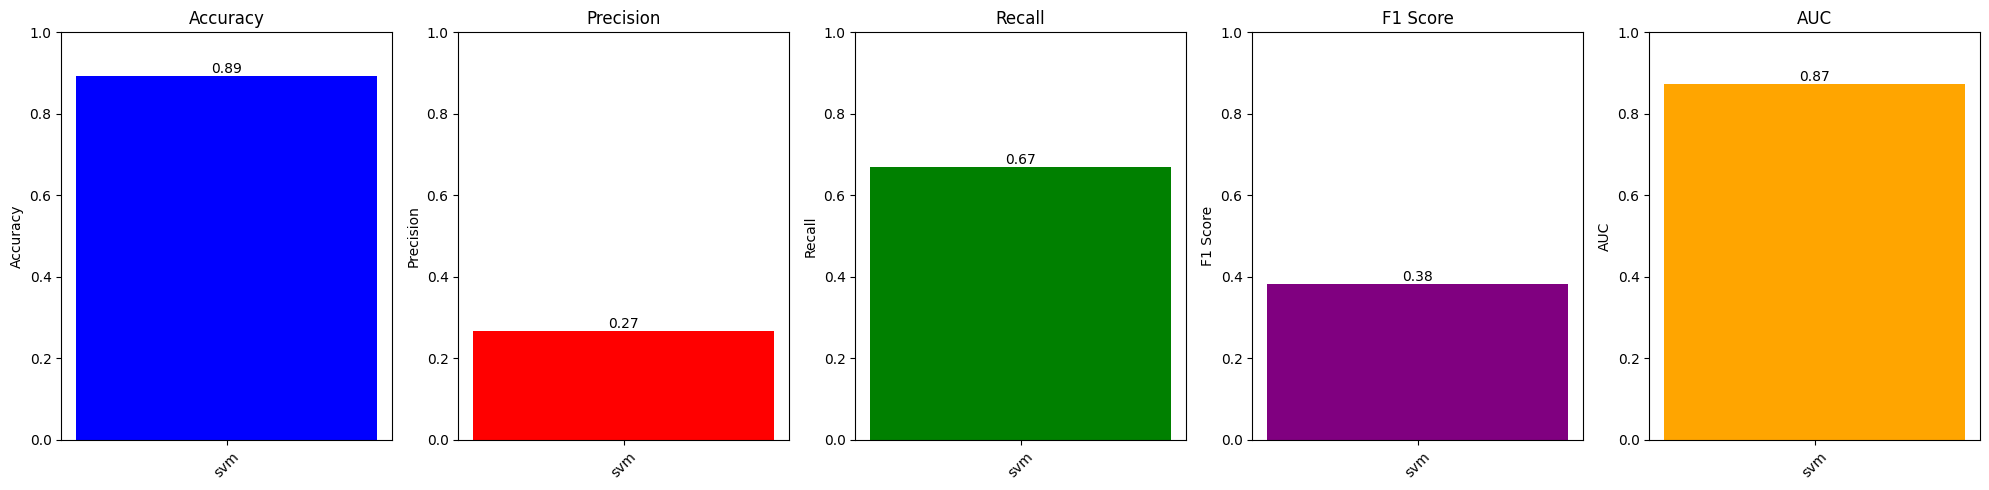

In [49]:
# plot graphs
import matplotlib.pyplot as plt

# Define model names and scores
models = [name for name, _ in accuracy_scores]
accuracy_values = [score for _, score in accuracy_scores]
precision_values = [score for _, score in precision_scores]
recall_values = [score for _, score in recall_scores]
f1_values = [score for _, score in f1_scores]
auc_values = [score for _, score in auc_scores]

# Create subplots for each metric
fig, axes = plt.subplots(1, 5, figsize=(20, 5))

# Function to add value labels on the bars for each axis
def add_value_labels(ax, bars):
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, yval, f'{yval:.2f}', 
                ha='center', va='bottom', fontsize=10)

# Plot Accuracy
bars_acc = axes[0].bar(models, accuracy_values, color='blue')
axes[0].set_title('Accuracy')
axes[0].set_ylabel('Accuracy')
axes[0].set_ylim(0, 1)  # Set y-limits for better visual comparison
add_value_labels(axes[0], bars_acc)  # Add value labels for Accuracy

# Plot Precision
bars_prec = axes[1].bar(models, precision_values, color='red')
axes[1].set_title('Precision')
axes[1].set_ylabel('Precision')
axes[1].set_ylim(0, 1)
add_value_labels(axes[1], bars_prec)  # Add value labels for Precision

# Plot Recall
bars_recall = axes[2].bar(models, recall_values, color='green')
axes[2].set_title('Recall')
axes[2].set_ylabel('Recall')
axes[2].set_ylim(0, 1)
add_value_labels(axes[2], bars_recall)  # Add value labels for Recall

# Plot F1 Score
bars_f1 = axes[3].bar(models, f1_values, color='purple')
axes[3].set_title('F1 Score')
axes[3].set_ylabel('F1 Score')
axes[3].set_ylim(0, 1)
add_value_labels(axes[3], bars_f1)  # Add value labels for F1 Score

# Plot AUC
bars_auc = axes[4].bar(models, auc_values, color='orange')
axes[4].set_title('AUC')
axes[4].set_ylabel('AUC')
axes[4].set_ylim(0, 1)
add_value_labels(axes[4], bars_auc)  # Add value labels for AUC

# Rotate x-axis labels for better readability
for ax in axes:
    ax.set_xticklabels(models, rotation=45)

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

Test with feature selected columns

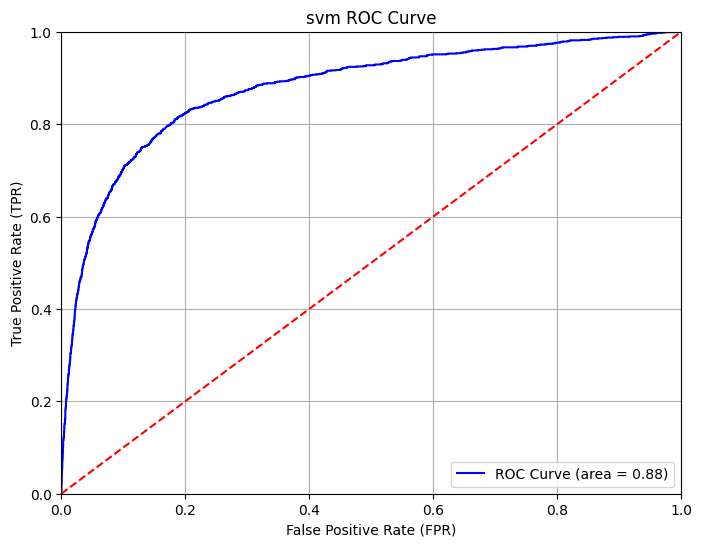


Confusion Matrix for svm:
 [[18929  3719]
 [  251   933]]
Accuracy:
svm: 0.8334172541121182

Precision:
svm: 0.20055889939810834

Recall:
svm: 0.7880067567567568

F1:
svm: 0.3197395476353667

AUC):
svm: 0.8779337057385892


In [50]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc

accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
auc_scores = []
pr_scores = []
avg_p_scores = []

for name, pipeline in pipelines_selected.items():

    y_pred = pipeline.predict(X_test_selected)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    y_probs = pipeline.predict_proba(X_test_selected)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_probs)
    roc_auc = auc(fpr, tpr)

    precision1, recall1, _ = precision_recall_curve(y_test, y_probs)
    pr_auc = auc(recall1, precision1)

    avg_pr = average_precision_score(y_test, y_probs)
    
    # Append scores to lists
    accuracy_scores.append((name, accuracy))
    precision_scores.append((name, precision))
    recall_scores.append((name, recall))
    f1_scores.append((name, f1))
    auc_scores.append((name, roc_auc))
    pr_scores.append((name, pr_auc))
    avg_p_scores.append((name, avg_pr)) 
    
    # Plotting the ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', label='ROC Curve (area = {:.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title(f'{name} ROC Curve')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

    # Print the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    print(f"\nConfusion Matrix for {name}:\n", cm)


# Print evaluation metrics
print("Accuracy:")
for name, score in accuracy_scores:
    print(f"{name}: {score}")

print("\nPrecision:")
for name, score in precision_scores:
    print(f"{name}: {score}")

print("\nRecall:")
for name, score in recall_scores:
    print(f"{name}: {score}")

print("\nF1:")
for name, score in f1_scores:
    print(f"{name}: {score}")

print("\nAUC):")
for name, score in auc_scores:
    print(f"{name}: {score}")

/var/folders/r7/7xn5t9gj65x3tw58b7rmvtmm0000gn/T/ipykernel_2218/824861330.py:58: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(models, rotation=45)
/var/folders/r7/7xn5t9gj65x3tw58b7rmvtmm0000gn/T/ipykernel_2218/824861330.py:58: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(models, rotation=45)
/var/folders/r7/7xn5t9gj65x3tw58b7rmvtmm0000gn/T/ipykernel_2218/824861330.py:58: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(models, rotation=45)
/var/folders/r7/7xn5t9gj65x3tw58b7rmvtmm0000gn/T/ipykernel_2218/824861330.py:58: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(models, rotation=

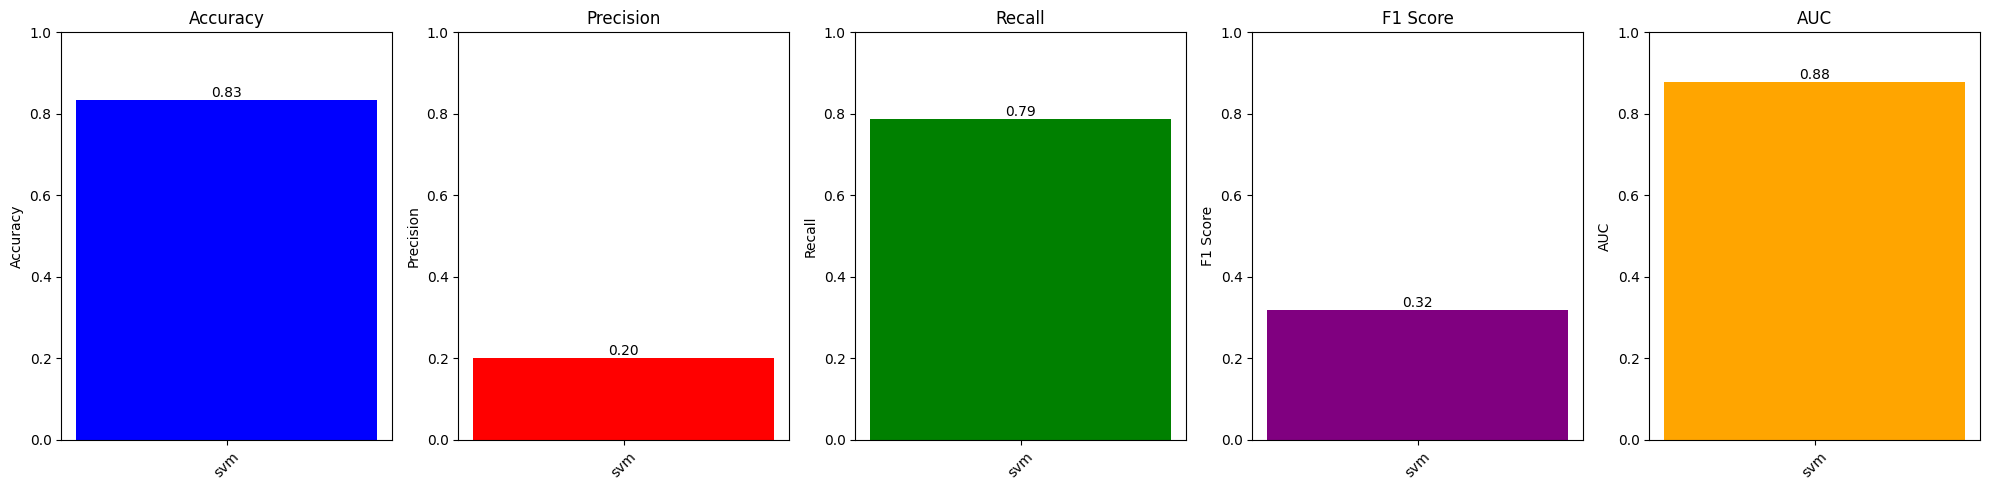

In [51]:
import matplotlib.pyplot as plt

# Define model names and scores
models = [name for name, _ in accuracy_scores]
accuracy_values = [score for _, score in accuracy_scores]
precision_values = [score for _, score in precision_scores]
recall_values = [score for _, score in recall_scores]
f1_values = [score for _, score in f1_scores]
auc_values = [score for _, score in auc_scores]

# Create subplots for each metric
fig, axes = plt.subplots(1, 5, figsize=(20, 5))

# Function to add value labels on the bars for each axis
def add_value_labels(ax, bars):
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, yval, f'{yval:.2f}', 
                ha='center', va='bottom', fontsize=10)

# Plot Accuracy
bars_acc = axes[0].bar(models, accuracy_values, color='blue')
axes[0].set_title('Accuracy')
axes[0].set_ylabel('Accuracy')
axes[0].set_ylim(0, 1)  # Set y-limits for better visual comparison
add_value_labels(axes[0], bars_acc)  # Add value labels for Accuracy

# Plot Precision
bars_prec = axes[1].bar(models, precision_values, color='red')
axes[1].set_title('Precision')
axes[1].set_ylabel('Precision')
axes[1].set_ylim(0, 1)
add_value_labels(axes[1], bars_prec)  # Add value labels for Precision

# Plot Recall
bars_recall = axes[2].bar(models, recall_values, color='green')
axes[2].set_title('Recall')
axes[2].set_ylabel('Recall')
axes[2].set_ylim(0, 1)
add_value_labels(axes[2], bars_recall)  # Add value labels for Recall

# Plot F1 Score
bars_f1 = axes[3].bar(models, f1_values, color='purple')
axes[3].set_title('F1 Score')
axes[3].set_ylabel('F1 Score')
axes[3].set_ylim(0, 1)
add_value_labels(axes[3], bars_f1)  # Add value labels for F1 Score

# Plot AUC
bars_auc = axes[4].bar(models, auc_values, color='orange')
axes[4].set_title('AUC')
axes[4].set_ylabel('AUC')
axes[4].set_ylim(0, 1)
add_value_labels(axes[4], bars_auc)  # Add value labels for AUC

# Rotate x-axis labels for better readability
for ax in axes:
    ax.set_xticklabels(models, rotation=45)

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

Visualise Metrics

In [52]:
# # Define model names and scores
# models = [name for name, _ in accuracy_scores]
# accuracy_values = [score for _, score in accuracy_scores]
# recall_values = [score for _, score in recall_scores]


# # Create subplots for each metric
# fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# # Plot MAE
# axes[0].bar(models, accuracy_values, color='blue')
# axes[0].set_title('Accuracy')
# axes[0].set_ylabel('Accuracy')

# # Plot RMSE
# axes[1].bar(models,recall_values , color='green')
# axes[1].set_title('Recall')
# axes[1].set_ylabel('Recall')


# # Rotate x-axis labels for better readability
# for ax in axes:
#     ax.set_xticklabels(models, rotation=45)

# # Adjust layout
# plt.tight_layout()

# # Show plot
# plt.show()

### Hyperparameter Tuning

In [57]:
from scipy.stats import randint, uniform
import numpy as np
# Setting up parameter distributions for each tunable classifier
param_distributions = {
    # 'logistic': {
    #     'logisticregression__C': uniform(0.01, 10),  # Testing values from 0.01 to 10
    #     'logisticregression__penalty': ['l1', 'l2'],   # Using L1 or L2 regularization
    #     'logisticregression__solver': ['liblinear', 'lbfgs'],  # Choosing solver
    #     'logisticregression__max_iter': randint(100, 500),  # Maximum iterations for convergence
    #     'logisticregression__tol': uniform(1e-5, 1e-3)  # Tolerance for stopping criteria
    # },
    # 'rf': {
    #     'randomforestclassifier__n_estimators': randint(100, 500),
    #     'randomforestclassifier__max_features': uniform(0.1, 0.9),
    #     'randomforestclassifier__max_depth': randint(3, 30),
    #     'randomforestclassifier__min_samples_split': randint(2, 20),
    #     'randomforestclassifier__min_samples_leaf': randint(1, 20)
    # },
    # 'gb': {
    #     'gradientboostingclassifier__n_estimators': randint(100, 500),
    #     'gradientboostingclassifier__learning_rate': uniform(0.01, 0.3),
    #     'gradientboostingclassifier__max_depth': randint(3, 15)
    # },
    # 'xgb': {
    #     'xgbclassifier__n_estimators': randint(100, 500),
    #     'xgbclassifier__learning_rate': uniform(0.01, 0.3),
    #     'xgbclassifier__max_depth': randint(3, 15),
    #     'xgbclassifier__min_child_weight': randint(1, 10),
    #     'xgbclassifier__colsample_bytree': uniform(0.5, 0.5)
    # },
    'svm': {
        'svc__C': np.logspace(-3, 3, 7),
        'svc__gamma': ['scale', 'auto'] + np.logspace(-3, 3, 7).tolist(),
        'svc__kernel': ['linear', 'poly', 'rbf', 'sigmoid']
    }
}


In [54]:
from sklearn.model_selection import RandomizedSearchCV
def optimize_pipelines(pipelines, param_distributions, X_train_selected, y_train):
    optimized_pipelines = {}

    # Perform hyperparameter tuning for each model
    for name, pipeline in pipelines.items():
        if name in param_distributions:
            print(f"Tuning hyperparameters for {name}...")
            # Create RandomizedSearchCV object
            # scoring=make_scorer(recall_score)
            random_search = RandomizedSearchCV(pipeline, param_distributions[name], scoring='recall', n_iter=20, cv=5, random_state=42, n_jobs=-1)
            # Fit RandomizedSearchCV
            random_search.fit(X_train_selected, y_train)
            # Print best parameters and best score
            print("Best parameters:", random_search.best_params_)
            print("Best score:", -random_search.best_score_)
            print()
            # Store the best estimator in the optimized pipelines dictionary
            optimized_pipelines[name] = random_search.best_estimator_

    return optimized_pipelines

In [58]:
#  or use X_train_resampled
optimized_pipelines = optimize_pipelines(pipelines_selected, param_distributions, X_train_selected_resampled, y_train_resampled)

Tuning hyperparameters for svm...


KeyboardInterrupt: 

In [ ]:
accuracy_scores_optimized = []
precision_scores_optimized = []
recall_scores_optimized = []
f1_scores_optimized = []
auc_scores_optimized = []
pr_scores_optimized = []
avg_p_scores_optimized = []

for name, pipeline in optimized_pipelines.items():
    y_pred = pipeline.predict(X_test_selected)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    y_probs = pipeline.predict_proba(X_test_selected)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_probs)
    roc_auc = auc(fpr, tpr)
    precision1, recall1, _ = precision_recall_curve(y_test, y_probs)
    pr_auc = auc(recall1, precision1)

    avg_pr = average_precision_score(y_test, y_probs)

    # Append scores to lists
    accuracy_scores_optimized.append((name, accuracy))
    precision_scores_optimized.append((name, precision))
    recall_scores_optimized.append((name, recall))
    f1_scores_optimized.append((name, f1))
    auc_scores_optimized.append((name, roc_auc))
    pr_scores_optimized.append((name, pr_auc))
    avg_p_scores_optimized.append((name, avg_pr))

    # Plotting the ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', label='ROC Curve (area = {:.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title(f'{name} ROC Curve')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

    # Print the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    print(f"\nConfusion Matrix for {name}:\n", cm)

print("After Hyperparameter tuning and Feature Selection")
# Print evaluation metrics
print("Accuracy:")
for name, score in accuracy_scores:
    print(f"{name}: {score}")

print("\nPrecision:")
for name, score in precision_scores:
    print(f"{name}: {score}")

print("\nRecall:")
for name, score in recall_scores:
    print(f"{name}: {score}")

print("\nF1:")
for name, score in f1_scores:
    print(f"{name}: {score}")

print("\nAUC):")
for name, score in auc_scores:
    print(f"{name}: {score}")

In [ ]:
# Plot
models_op = [name for name, _ in accuracy_scores_optimized]
accuracy_values_op = [score for _, score in accuracy_scores_optimized]
recall_values_op = [score for _, score in recall_scores_optimized]
auc_values_op = [score for _, score in auc_scores_optimized]

accuracy_values = [score for _, score in accuracy_scores]
recall_values = [score for _, score in recall_scores]
auc_values = [score for _, score in auc_scores]


# Create subplots for each metric
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Set up bar width and index
bar_width = 0.35
index = range(len(models_op))

# Plot Accuracy
bar1 = axes[0].bar(index, accuracy_values, bar_width, color='red', label='Before Tuning')
bar2 = axes[0].bar([i + bar_width for i in index], accuracy_values_op, bar_width, color='blue', label='After Tuning')

axes[0].set_title('Model Accuracy')
axes[0].set_xticks([i + bar_width / 2 for i in index])
axes[0].set_xticklabels(models_op, rotation=45)
axes[0].set_ylabel('Accuracy')
axes[0].legend()

# Plot Recall
bar3 = axes[1].bar(index, recall_values, bar_width, color='orange', label='Before Tuning')
bar4 = axes[1].bar([i + bar_width for i in index], recall_values_op, bar_width, color='cyan', label='After Tuning')

axes[1].set_title('Model Recall')
axes[1].set_xticks([i + bar_width / 2 for i in index])
axes[1].set_xticklabels(models_op, rotation=45)
axes[1].set_ylabel('Recall')
axes[1].legend()

# Plot AUC
bar5 = axes[2].bar(index, auc_values, bar_width, color='green', label='Before Tuning')
bar6 = axes[2].bar([i + bar_width for i in index], auc_values_op, bar_width, color='purple', label='After Tuning')

axes[2].set_title('Area Under Curve (AUC)')
axes[2].set_xticks([i + bar_width / 2 for i in index])
axes[2].set_xticklabels(models_op, rotation=45)
axes[2].set_ylabel('AUC')
axes[2].legend()

# Adjust layout
plt.suptitle('Model Performance Comparison: Before and After Hyperparameter Tuning')
plt.tight_layout()

# Show plot
plt.show()


# TASK 2

Download datasets

In [4]:
# !aws s3 cp --no-sign-request s3://sg-nex-data/data/processed_data/m6Anet/SGNex_A549_directRNA_replicate5_run1/data.json ~/Desktop/NUS/Y4/DSA4262/Team_Project/data
# !aws s3 cp --no-sign-request s3://sg-nex-data/data/processed_data/m6Anet/SGNex_Hct116_directRNA_replicate3_run1/data.json ~/Desktop/NUS/Y4/DSA4262/Team_Project/data
# !aws s3 cp --no-sign-request s3://sg-nex-data/data/processed_data/m6Anet/SGNex_HepG2_directRNA_replicate6_run1/data.json ~/Desktop/NUS/Y4/DSA4262/Team_Project/data
# !aws s3 cp --no-sign-request s3://sg-nex-data/data/processed_data/m6Anet/SGNex_K562_directRNA_replicate4_run1/data.json ~/Desktop/NUS/Y4/DSA4262/Team_Project/data
# !aws s3 cp --no-sign-request s3://sg-nex-data/data/processed_data/m6Anet/SGNex_MCF7_directRNA_replicate3_run1/data.json ~/Desktop/NUS/Y4/DSA4262/Team_Project/data

download: s3://sg-nex-data/data/processed_data/m6Anet/SGNex_Hct116_directRNA_replicate3_run1/data.json to ../../NUS/Y4/DSA4262/Team_Project/data/data.json


In [3]:
def json_to_dataframe(json_file_path):
    data = []
    
    # Open and read the gzipped JSON file
    with open(json_file_path, 'r') as file:
        # Read the file line-by-line
        for line in file:
            try:
                json_data = json.loads(line)  # Load each line as a separate JSON object
                
                # Loop through the transcripts in the JSON data
                for transcript_id, positions in json_data.items():
                    for position, sequences in positions.items():
                        for sequence, reads in sequences.items():
                            # Create the 5-mers for the position -1, 0, and 1 from the 7-mer (sequence)
                            fivemer_neg_1 = sequence[:5]  # First 5 nucleotides (e.g., "AAGAC")
                            fivemer_0 = sequence[1:6]     # Middle 5 nucleotides (e.g., "AGACC")
                            fivemer_1 = sequence[2:]      # Last 5 nucleotides (e.g., "GACCA")
                            
                            # For each read in the list of reads, create a row
                            for read in reads:
                                row = [
                                    transcript_id,                # transcript_id
                                    int(position)-1,              # position_neg_1
                                    read[0], read[1], read[2],    # dwelling_time_neg_1, sd_neg_1, mean_neg_1
                                    int(position),                # position_0
                                    read[3], read[4], read[5],    # dwelling_time_0, sd_0, mean_0
                                    int(position)+1,              # position_1
                                    read[6], read[7], read[8],    # dwelling_time_1, sd_1, mean_1
                                    sequence,                     # ori_nucleotide (7-mer)
                                    fivemer_neg_1,                # fivemer_neg_1
                                    fivemer_0,                    # fivemer_0
                                    fivemer_1                     # fivemer_1
                                ]
                                data.append(row)
            except json.JSONDecodeError:
                print(f"Skipping invalid JSON line: {line}")
    
    # Define the columns, including the new 5-mer and ori_nucleotide columns
    columns = [
        'transcript_id', 'position_neg_1', 'dwelling_time_neg_1', 'sd_neg_1', 'mean_neg_1',
        'transcript_position', 'dwelling_time_0', 'sd_0', 'mean_0',
        'position_1', 'dwelling_time_1', 'sd_1', 'mean_1',
        'ori_nucleotide', 'fivemer_neg_1', 'fivemer_0', 'fivemer_1'
    ]
    
    # Create the dataframe
    df = pd.DataFrame(data, columns=columns)
    
    return df


In [4]:
# # convert to df and save the df
# df = json_to_dataframe('/Users/rachels/Desktop/NUS/Y4/DSA4262/Team_Project/data/SGNex_K562_directRNA_replicate4_run1_data.json')  # Replace with actual path
# print(df.head())

# df.to_csv('/Users/rachels/Desktop/NUS/Y4/DSA4262/Team_Project/data/SGNex_K562_directRNA_replicate4_run1_data.csv', index=False) # save file as csv
# SGNex_K562_directRNA_replicate4_run1_df = df

In [28]:
# SGNex_A549_directRNA_replicate5_run1_df
# SGNex_Hct116_directRNA_replicate3_run1_df
# SGNex_K562_directRNA_replicate4_run1_df
# SGNex_HepG2_directRNA_replicate6_run1_df
# SGNex_MCF7_directRNA_replicate3_run1_df

In [3]:
# read in all the files
import pandas as pd

SGNex_A549_directRNA_replicate5_run1_df = pd.read_csv('/Users/rachels/Desktop/NUS/Y4/DSA4262/Team_Project/data/Task 2/raw/SGNex_A549_directRNA_replicate5_run1_data.csv', sep=',')
SGNex_Hct116_directRNA_replicate3_run1_df = pd.read_csv('/Users/rachels/Desktop/NUS/Y4/DSA4262/Team_Project/data/Task 2/raw/SGNex_Hct116_directRNA_replicate3_run1_data.csv', sep=',')
SGNex_K562_directRNA_replicate4_run1_df = pd.read_csv('/Users/rachels/Desktop/NUS/Y4/DSA4262/Team_Project/data/Task 2/raw/SGNex_K562_directRNA_replicate4_run1_data.csv', sep=',')
SGNex_HepG2_directRNA_replicate6_run1_df = pd.read_csv('/Users/rachels/Desktop/NUS/Y4/DSA4262/Team_Project/data/Task 2/raw/SGNex_HepG2_directRNA_replicate6_run1_data.csv', sep=',')
SGNex_MCF7_directRNA_replicate3_run1_df = pd.read_csv('/Users/rachels/Desktop/NUS/Y4/DSA4262/Team_Project/data/Task 2/raw/SGNex_MCF7_directRNA_replicate3_run1_data.csv', sep=',')

In [27]:
# # feature engineer AND normalise

# avg_K562_directRNA_replicate4_run1_df = feature_engineeer_mean(merged_K562_directRNA_replicate4_run1_df)
# avg_K562_directRNA_replicate4_run1_df = feature_engineer_read_count(avg_K562_directRNA_replicate4_run1_df)

# normalise
# avg_K562_directRNA_replicate4_run1_df = normalise(avg_K562_directRNA_replicate4_run1_df)

files = [SGNex_A549_directRNA_replicate5_run1_df,
SGNex_Hct116_directRNA_replicate3_run1_df,
SGNex_K562_directRNA_replicate4_run1_df,
SGNex_HepG2_directRNA_replicate6_run1_df,
SGNex_MCF7_directRNA_replicate3_run1_df]

for file in files:
    file = feature_engineeer_mean(file)
    file = feature_engineer_read_count(file)
    file = normalise(file)

In [28]:
#  add in cell line column
SGNex_A549_directRNA_replicate5_run1_df['cell_line'] = "A549"
SGNex_Hct116_directRNA_replicate3_run1_df['cell_line'] = "Hct116"
SGNex_K562_directRNA_replicate4_run1_df['cell_line'] = "K562"
SGNex_HepG2_directRNA_replicate6_run1_df['cell_line'] = "HepG2"
SGNex_MCF7_directRNA_replicate3_run1_df['cell_line'] = "MCF7"


# df['status'] = df['label'].apply(lambda x: 'modified' if x == 1 else "unmodified")

In [30]:
# merge all the cell line dfs together
# merged_df = pd.concat(files, ignore_index=True)
merged_df.to_csv("/Users/rachels/Desktop/NUS/Y4/DSA4262/Team_Project/data/Task 2/raw/merged_data.csv", index = False)

OSError: [Errno 28] No space left on device

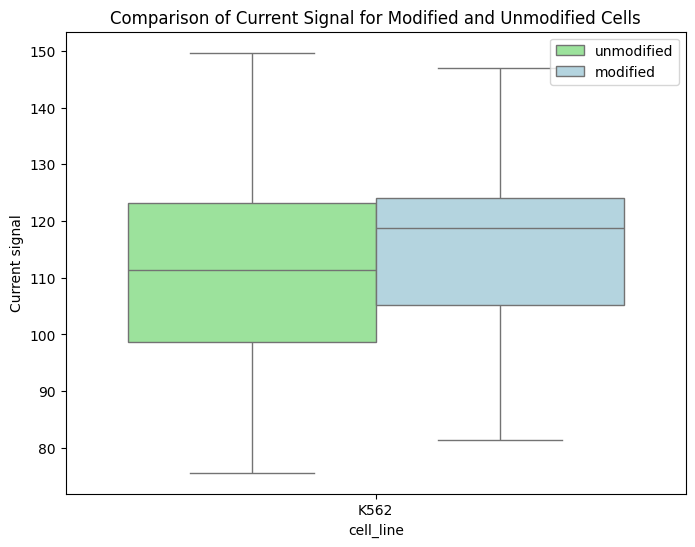

In [19]:
# plot graph C as following the slides [Distribution of m6A Modifications Across Cell Lines]

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Create the boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(x='cell_line', y='mean_0', hue='status', data=df, palette=['lightgreen', 'lightblue'])

# Set labels and title
plt.title('Comparison of Mean m6A Modifications Across Cell Lines for Condition 1')
plt.ylabel('Mean m6A Modification')
plt.legend(loc='upper right')
plt.xlabel('Cell Line')
# Show the plot
plt.show()



Modified M6A genes display higher mean values

In [20]:
df.columns

Index(['transcript_id', 'position_neg_1', 'dwelling_time_neg_1', 'sd_neg_1',
       'mean_neg_1', 'transcript_position', 'dwelling_time_0', 'sd_0',
       'mean_0', 'position_1', 'dwelling_time_1', 'sd_1', 'mean_1',
       'ori_nucleotide', 'fivemer_neg_1', 'fivemer_0', 'fivemer_1', 'gene_id',
       'label', 'cell_line', 'status'],
      dtype='object')

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/seaborn/axisgrid.py:718: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/seaborn/axisgrid.py:854: FutureWarning:

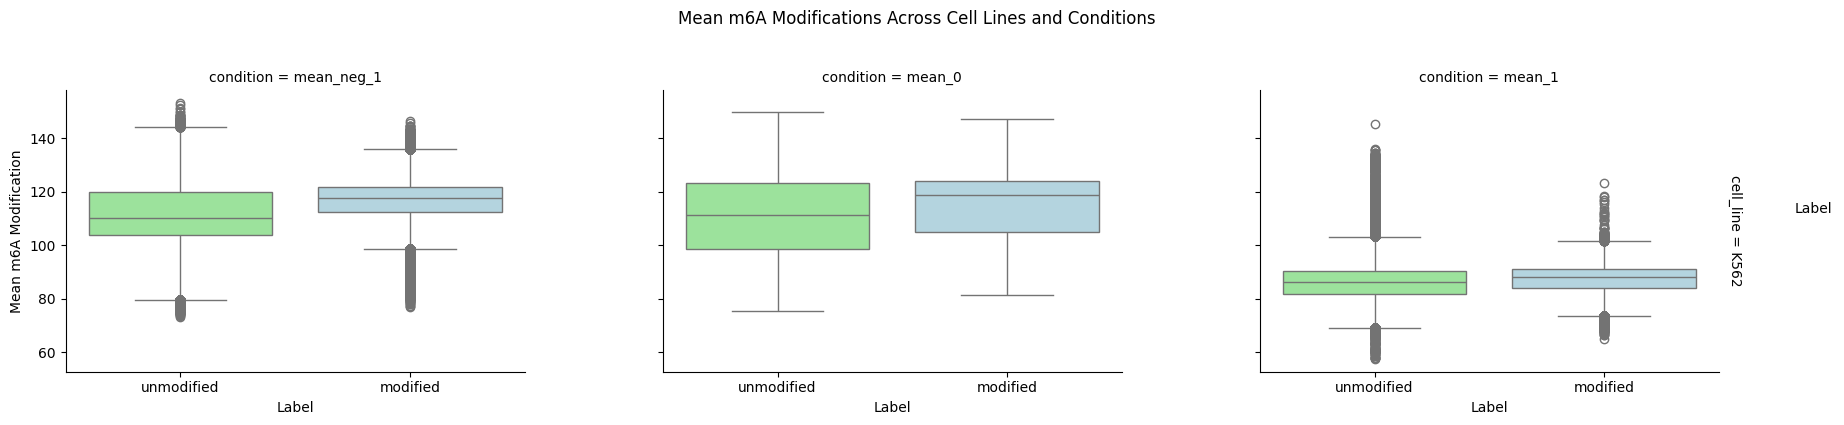

In [14]:
# Define the custom palette based on 'label'
palette = {'unmodified': 'lightgreen', 'modified': 'lightblue'}

# Melt the DataFrame for plotting
# df_melted = df.melt(id_vars=['cell_line', 'status'], value_vars=['mean_neg_1', 'mean_0', 'mean_1'],
#                     var_name='condition', value_name='mean_value')

# Create a FacetGrid for the boxplots
g = sns.FacetGrid(df_melted, col='condition', row='cell_line', margin_titles=True, height=4, aspect=1.5)
g.map(sns.boxplot, 'status', 'mean_value', palette=palette)

# Add title and adjust position
g.fig.suptitle('Mean m6A Modifications Across Cell Lines and Conditions', y=1.05)  # Position the title higher
g.set_axis_labels('Label', 'Mean m6A Modification')  # Set axis labels

# Adjust the layout to prevent overlap with larger gaps
g.fig.subplots_adjust(top=0.85, hspace=0.7, wspace=0.3)
plt.show()


In [1]:
# Bin transcript_position into intervals to reduce the number of bars
df['transcript_position_bin'] = pd.cut(df['transcript_position'], bins=40)  # Adjust bin size as needed

# Group by transcript_position_bin and status, calculating the mean of mean_0
df_grouped = df.groupby(['transcript_position_bin', 'status']).agg({'mean_0': 'mean'}).reset_index()

# Create a bar plot with binned transcript_position on the x-axis
plt.figure(figsize=(12, 6))
sns.barplot(data=df_grouped, x='transcript_position_bin', y='mean_0', hue='status', palette=['lightgreen', 'lightblue'])

# Add title and labels
plt.title('Mean m6A Modifications by Binned Transcript Position and Status', pad=20)
plt.xlabel('Transcript Position (Binned)')
plt.ylabel('Mean m6A Modification (mean_0)')

# Rotate x-axis labels for readability
plt.xticks(rotation=45)

plt.show()


NameError: name 'pd' is not defined